# Roi-based traces

In [1]:
import numpy as np
import cv2
import tifffile
import h5py 
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

from vis_utils import *

## First, read the locations from DLC

In [2]:
which_neuron = 0
num_frames = 100
sz=(18,18)

In [3]:
# mCherry
folder_name = '/users/charles.fieseler/test_worm1_data/immobilized/'
fname = 'test_500frames_7slice.ome.tiffDLC_resnet50_Immobilized_mCherryJul24shuffle1_5500.h5'

annotation_fname = os.path.join(folder_name, fname)

this_xy, this_prob = xy_from_dlc_dat(annotation_fname, which_neuron=which_neuron, num_frames=num_frames)

Text(0.5, 1.0, 'Confidence of tracking')

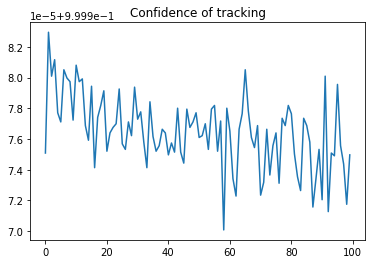

In [7]:
plt.plot(this_prob)
plt.title('Confidence of tracking')
# plt.ylim(0,1);

## Next, read in 3d video

In [8]:
which_z = 7 # The actually tracked slice
num_frames = 50
# sz=(17,17,9)
sz=(17,17,3)

In [9]:
folder_name = '/users/charles.fieseler/test_worm1_data/immobilized/'
# fname = 'test_gcamp_50frames_allslice.ome.tiff'
fname = 'test_uint16_50frames_allslice.ome.tiff'
# Pre-aligned and background subtracted
# fname = 'test_bg_subtract_100frames.ome.tiff'

video3d_fname = os.path.join(folder_name, fname)

cropped_dat = get_crop_from_ometiff(video3d_fname, this_xy, which_z, num_frames, sz)

Reading video...
Read video of shape (50, 14, 209, 505)
Reading frame 0/49 at position [115.25837708  25.61630821   7.        ]
Reading frame 1/49 at position [115.41025543  25.43869019   7.        ]
Reading frame 2/49 at position [115.3297348   25.27738571   7.        ]
Reading frame 3/49 at position [115.4981308   25.05325317   7.        ]
Reading frame 4/49 at position [115.30277252  25.22064209   7.        ]
Reading frame 5/49 at position [115.33248138  25.74401474   7.        ]
Reading frame 6/49 at position [115.54463196  25.64678001   7.        ]
Reading frame 7/49 at position [115.21278381  25.29421806   7.        ]
Reading frame 8/49 at position [115.54557037  25.67520714   7.        ]
Reading frame 9/49 at position [115.40756989  25.5568428    7.        ]
Reading frame 10/49 at position [115.61367798  25.1490345    7.        ]
Reading frame 11/49 at position [115.3267746   25.61333275   7.        ]
Reading frame 12/49 at position [115.18125153  25.49831581   7.        ]
Readi

In [10]:
import tifffile
full_dat = tifffile.imread(video3d_fname)
full_dat = full_dat / np.max(full_dat)
f = lambda z, t : plt.imshow(full_dat[t,z,:,:]);
interact(f, **{'t':(0,full_dat.shape[0]), 'z':(0,full_dat.shape[1])});

interactive(children=(IntSlider(value=7, description='z', max=14), IntSlider(value=25, description='t', max=50…

In [11]:
f = lambda k : plt.imshow(tifffile.imread(video3d_fname, key=k));
interact(f, **{'k':(0,1000)});
print("Reading the original OME-TIFF per frame, not all at once")

interactive(children=(IntSlider(value=500, description='k', max=1000), Output()), _dom_classes=('widget-intera…

Reading the original OME-TIFF per frame, not all at once


In [12]:
mn, mx = np.min(cropped_dat), np.max(cropped_dat)
f = lambda z, t : plt.imshow(cropped_dat[:,:,z,t].astype('uint16'), vmin=mn, vmax=mx);
interact(f, **{'t':(0,num_frames-1), 'z':(0,sz[2]-1)});

interactive(children=(IntSlider(value=1, description='z', max=2), IntSlider(value=24, description='t', max=49)…

In [13]:
# SAVE
save_fname = 'test'
save_video4d(save_fname, cropped_dat)

## Find Peaks in 3d

In [14]:
peaks_ind = np.zeros((num_frames,3))
peaks_val = []
frame_sz = cropped_dat.shape[:-1]
for t in range(num_frames):
    frame = cropped_dat[...,t]
    max_ind = np.argmax(frame)
    max_ind = np.unravel_index(max_ind, frame_sz)
    peaks_ind[t,:] = np.array(max_ind)
    peaks_val.append(frame[max_ind])


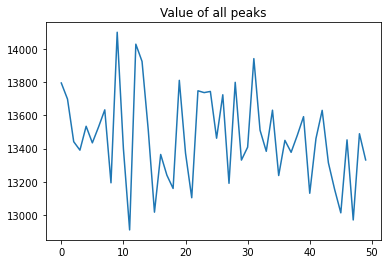

In [15]:
plt.plot(peaks_val)
# plt.plot(100*np.array([i>0.6 for i in this_prob[:num_frames]]))
# plt.legend(('Peak value', 'High tracking confidence'))
plt.title('Value of all peaks');
plt.savefig('unfiltered-peaks')

In [16]:
# fig = plt.figure(figsize=(20,20))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(peaks_ind[:,0], peaks_ind[:,1], peaks_ind[:,2])
# plt.title('All peak locations')

In [17]:
def plot3d_with_max(z, t, max_ind): 
    plt.imshow(cropped_dat[:,:,z,t])
    plt.colorbar()
    x, y = max_ind[t,1], max_ind[t,0]
    if z == max_ind[t,2]:
        plt.scatter(x, y, marker='x', c='r')
    plt.title(f"Max for t={t} is on z={max_ind[t,2]}, xy={x},{y}")

# interact(plot3d_with_max, t=(0,num_frames-1), z=(0,sz[2]-1), max_ind=fixed(peaks_ind))
interact(plot3d_with_max, **{'t':(0,num_frames-1), 'z':(0,sz[2]-1), 'max_ind':fixed(peaks_ind)})

interactive(children=(IntSlider(value=1, description='z', max=2), IntSlider(value=24, description='t', max=49)…

<function __main__.plot3d_with_max(z, t, max_ind)>

## Do a Gaussian blur, then find the peaks again

In [18]:
import cv2
from itertools import product

In [19]:
blurred_dat = np.zeros_like(cropped_dat)
sz = blurred_dat.shape
for z, t in product(range(sz[2]), range(sz[3])):
    blurred_dat[:,:,z,t] = cv2.GaussianBlur(cropped_dat[:,:,z,t],(5,5),0)

In [20]:
peaks_ind = np.zeros((num_frames,3))
peaks_val = []
frame_sz = blurred_dat.shape[:-1]
for t in range(num_frames):
    frame = blurred_dat[...,t]
    max_ind = np.argmax(frame)
    max_ind = np.unravel_index(max_ind, frame_sz)
    peaks_ind[t,:] = np.array(max_ind)
    peaks_val.append(frame[max_ind])


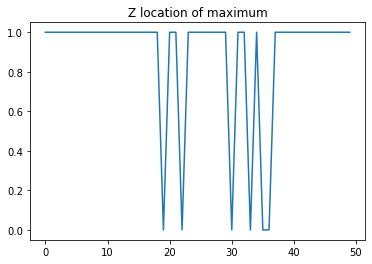

In [21]:
plt.plot(peaks_ind[:,2])
plt.title('Z location of maximum');
plt.savefig('Z-location')

In [22]:
def plot3d_with_max(z, t, max_ind): 
    plt.figure(figsize=(8,8))

    plt.imshow(blurred_dat[:,:,z,t])
    x, y = max_ind[t,1], max_ind[t,0]
#     plt.colorbar()
    if z == max_ind[t,2]:
        plt.scatter(x, y, marker='x', c='r')
    plt.title(f"Max for t={t} is on z={max_ind[t,2]}, xy={x},{y}")

# interact(plot3d_with_max, t=(0,num_frames-1), z=(0,sz[2]-1), max_ind=fixed(peaks_ind))
interact(plot3d_with_max, **{'t':(0,num_frames-1), 'z':(0,sz[2]-1), 'max_ind':fixed(peaks_ind)});

interactive(children=(IntSlider(value=1, description='z', max=2), IntSlider(value=24, description='t', max=49)…

In [23]:
from matplotlib.ticker import NullFormatter
from matplotlib import transforms

In [24]:
rot = transforms.Affine2D().rotate_deg(90)
nullfmt = NullFormatter()         # no labels

def plot3d_with_max_and_hist(z, t, max_ind): 
    # From: https://matplotlib.org/2.0.2/examples/pylab_examples/scatter_hist.html
    plt.figure(1, figsize=(8, 8))


    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    
    axIm = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

    # Actually display
    frame = blurred_dat[:,:,z,t]
    axIm.imshow(frame)
    x, y = max_ind[t,1], max_ind[t,0]
#     if z == max_ind[t,2]:
#         plt.scatter(x, y, marker='x', c='r')
#     plt.title(f"Max for t={t} is on z={max_ind[t,2]}, xy={x},{y}")
    
    axHistx.plot(np.max(frame, axis=0))
    
#     base = plt.gca().transData
    axHisty.plot(np.flip(np.max(frame, axis=1)), range(frame.shape[0]))#, transform=base+rot)
    

# interact(plot3d_with_max, t=(0,num_frames-1), z=(0,sz[2]-1), max_ind=fixed(peaks_ind))
interact(plot3d_with_max_and_hist, **{'t':(0,num_frames-1), 'z':(0,sz[2]-1), 'max_ind':fixed(peaks_ind)});

interactive(children=(IntSlider(value=1, description='z', max=2), IntSlider(value=24, description='t', max=49)…

## Take a 3x3x3 average around the peak

In [25]:
peaks333_val = np.zeros_like(peaks_val)
# peaks333_val_blur = np.zeros_like(peaks_val)
crop_sz=(3,3,3)
clip_sz=cropped_dat.shape

for i in range(num_frames):
    x_ind, y_ind, z_ind = get_crop_coords3d(peaks_ind[i,:], crop_sz, clip_sz=clip_sz)
    peaks333_val[i] = np.mean(cropped_dat[...,i][x_ind,:,:][:, y_ind,:][:,:, z_ind])
#     peaks333_val_blur[i] = np.mean(blurred_dat[...,i][x_ind,:,:][:, y_ind,:][:,:, z_ind])
    if peaks333_val[i] == 0:
        print(x_ind, y_ind, z_ind)


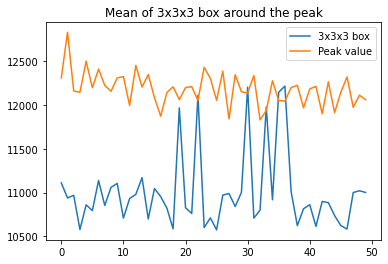

In [26]:
plt.plot(peaks333_val)
# plt.plot(peaks333_val_blur)
plt.plot(peaks_val)
# plt.legend(('3x3x3 box', '3x3x3 box on blurred data', 'Peak value'))
plt.legend(('3x3x3 box', 'Peak value'))
plt.title('Mean of 3x3x3 box around the peak');

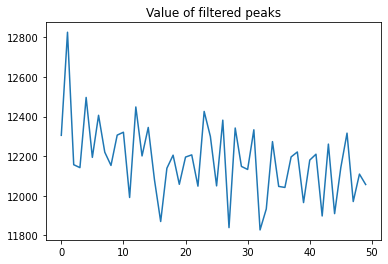

In [27]:
plt.plot(peaks_val)
plt.title('Value of filtered peaks')
plt.savefig('filtered-peaks')

# Scratch



## Do dNMF

In [25]:
from dNMF.Demix.dNMF import dNMF
import tifffile
import torch
import cv2
from itertools import product

/users/charles.fieseler/.conda/envs/DLC-preprocessing/lib/python3.7/site-packages/dNMF/WUtils/Transformations.py:1916: UserWarning: No module named 'dNMF.WUtils._transformations'
  warnings.warn(str(err))


In [26]:
# Video data
full_dat = tifffile.imread(video3d_fname)
full_dat = full_dat / np.max(full_dat)

blurred_dat = np.zeros_like(full_dat)
sz = blurred_dat.shape
for z, t in product(range(sz[2]), range(sz[3])):
    blurred_dat[:,:,z,t] = cv2.GaussianBlur(full_dat[:,:,z,t],(5,5),0)
    
blurred_dat = torch.tensor(np.transpose(blurred_dat, axes=(2,3,1,0))).float()

In [27]:
# Position data: make it 3d
xy0, this_prob = xy_from_dlc_dat(annotation_fname, which_neuron=0, num_frames=num_frames)
xy1, this_prob = xy_from_dlc_dat(annotation_fname, which_neuron=1, num_frames=num_frames)
all_xy = [np.flip(xy0[0]), np.flip(xy1[0])]
which_z = 7.0

this_xyz = torch.tensor(np.expand_dims([np.append(xy, which_z) for xy in all_xy],axis=2)).float()

In [28]:
print(this_xyz.shape)
print(full_dat.shape)


torch.Size([2, 3, 1])
(50, 14, 209, 505)


In [29]:
# %% Choosing the parameters
params = {'sigma_inv':.2, 
          'radius':5, 
          'step_S':0.1, 
          'gamma':0.1}

# start = time.time()
# Initialize using the following from the ground truth:
#  Initial positions
#  Radius
#  
# dnmf = dNMF(full_dat)
dnmf = dNMF(blurred_dat,params={'positions':this_xyz,\
    'radius':params['radius'],'step_S':params['step_S'],'gamma':params['gamma'],\
    'use_gpu':False,'initial_p':this_xyz[:,:,0],'sigma_inv':params['sigma_inv'],\
    'method':'1->t', 'verbose':False})

dnmf.optimize(lr=1e-4,n_iter=50,n_iter_c=2)

/users/charles.fieseler/.conda/envs/DLC-preprocessing/lib/python3.7/site-packages/dNMF/Demix/dNMF.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale = torch.tensor(params['scale']).float().to(device=device).squeeze() # microns per pixel


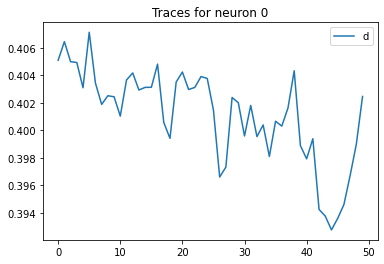

In [31]:
which_neuron = 0

plt.plot(dnmf.C[which_neuron,:])
plt.legend('dNMF')
plt.title('Traces for neuron {}'.format(which_neuron))
plt.savefig('dnmf-traces')

In [126]:
neuron_names = [str(i) for i in range(this_xyz.shape[0])]

dnmf.visualize_neurons('result3d', [['0','1']], neuron_names, blurred_dat)

## Fit a 3d Gaussian

Based on:
https://stackoverflow.com/questions/24666877/2d-gaussian-fitting-to-histogram

In [42]:
def mult_gaussFun_Fit(x,y,z,*m):
    A,x0,y0,z0,varx,vary,varz,rho,alpha = m
    X,Y,Z = np.meshgrid(x,y,z)
    assert rho != 1
    a = 1/(2*(1-rho**2))
    dist = A*np.exp(-a*( (X-x0)**2/(varx) + (Y-y0)**2/(vary) + (Z-z0)**2/(varz) - (2*rho/(np.sqrt(varx*vary*varz) ) )*(X-x0)*(Y-y0)*(Z-z0)))
    return dist.ravel()

In [43]:
from scipy.optimize import curve_fit

In [52]:
# Produce a number of points in x-y from 1 distribution. 
mean = [0,0,0]
cov = np.eye(3)
N = 3000
# x,y,z = np.random.multivariate_normal(mean,cov,N).T
xyz = np.random.multivariate_normal(mean,cov,N)

In [53]:
xyz.shape

(3000, 3)

In [54]:
H, edges = np.histogramdd(xyz)

In [ ]:
# Prep bins for histogram
bin_size = 0.2
max_edge = 2.5*(np.sqrt(cov[0][0])+np.sqrt(cov[1][1])) 
min_edge = -max_edge
bin_num = (max_edge-min_edge)/bin_size
bin_numPlus1 = bin_num + 1
bins = np.linspace(min_edge,max_edge,bin_numPlus1)

# Produce 2D histogram
H,xedges,yedges = np.histogram2d(x,y,bins,normed=False)
bin_centers_x = (xedges[:-1]+xedges[1:])/2.0
bin_centers_y = (yedges[:-1]+yedges[1:])/2.0

In [ ]:
# Initial Guess
p0 = (H.max(),mean[0],mean[1],cov[0][0],cov[1][1],0.5,np.pi/4)

# Curve Fit parameters
coeff, var_matrix = curve_fit(gauss.mult_gaussFun_Fit,(bin_centers_x,bin_centers_y),H,p0=p0)

## Actually just do a Gaussian kernel

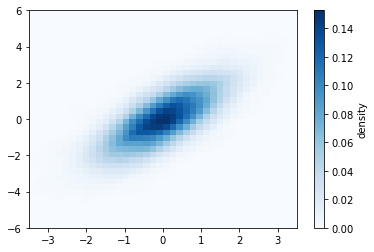

In [60]:
mean = [0, 0]
cov = [[1, 1], [1, 2]]
x, y = np.random.multivariate_normal(mean, cov, 10000).T

# fit an array of size [Ndim, Nsamples]
data = np.vstack([x, y])
kde = gaussian_kde(data)

# evaluate on a regular grid
xgrid = np.linspace(-3.5, 3.5, 40)
ygrid = np.linspace(-6, 6, 40)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

# Plot the result as an image
plt.imshow(Z.reshape(Xgrid.shape),
           origin='lower', aspect='auto',
           extent=[-3.5, 3.5, -6, 6],
           cmap='Blues')
cb = plt.colorbar()
cb.set_label("density")

(array([ 0.02787812, -0.49209117, -1.24973747, ..., -0.29762827,
        -1.51089312, -0.09095426]),
 array([ 0.15469938, -0.16263896, -2.33547902, ..., -0.49756739,
        -1.4176045 ,  0.31548077]))